# Demo Detection: Обработка данных, обучение, демонстрация и экспорт модели

Обучение модели YOLO26l было выполнено на M4 Pro MacBook Pro (24G RAM), YOLO26m
на RTX5060 (8G VRAM). Экспорт для Debian в формате ONNX для большей
совместимости.


In [1]:
import os
import shutil

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
import torch
from ultralytics import YOLO

from preprocessing import TestTaskDatasetPreprocessor


ROOT = "../../"

torch.cuda.is_available()


True

---


## Обработка данных

Исходные данные были представлены в виде директорий с кадрами из
соответствующих чанков видео. Все кадры оказались упорядочены, поэтому
построить соответствие между изображениями и аннотациями было нетрудно.
Описанный ниже класс даёт абстракцию для перевода из исходного формата в
подходящий для обучения YOLO26 от Ultralitycs.

Конкретно с нашими путями его следует использовть следущим образом. Чтобы 
упростить задачу детекции для модели, не включаем в выборку класс трейлера.


In [12]:
prefix = ROOT + "dataset/test_task_dl_26_12_2025/train_data/"
frames = [
    "2025-10-03_05_vt53_criterion_1_6_day_bw_panorama_1882x862",
    "2025-10-03_05_vt53_criterion_1_8_day_bw_panorama_1882x862",
    "2025-10-05T11-12_vt53_criterion_3_1_day_bw_panorama_1882x862",
]
annotations = [
    "annotations_task_2299_2025-10-03_05_vt53_criterion_1_6_day_bw"
    + "_panorama_1882x862.xml",
    "annotations_task_2303_2025-10-03_05_vt53_criterion_1_8_day_bw"
    + "_panorama_1882x862.xml",
    "annotations_task_2310_2025-10-05T11-12_vt53_criterion_3_1_day_bw"
    + "_panorama_1882x862.xml",
]

paths_aligned = []
for dir, file in zip(frames, annotations):
    paths = (prefix + dir, prefix + file)
    paths_aligned.append(paths)

dataset_root = ROOT + "dataset/test_task_dl_26_12_2025_yolo"
preprocessor = TestTaskDatasetPreprocessor(
    root=dataset_root,
    class_map={"car": 0, "truck": 1},
    image_dims=(1882.0, 862.0),
)

preprocessor.run(paths_aligned)

os.mkdir(dataset_root + "/test")
shutil.copy(
    prefix + "../test_data/test_video_10_sec.mp4",
    dataset_root + "/test/10.0s_video_test.mp4",
)

Processing 2025-10-03_05_vt53_criterion_1_6_day_bw_panorama_1882x862...
Processing 2025-10-03_05_vt53_criterion_1_8_day_bw_panorama_1882x862...
Processing 2025-10-05T11-12_vt53_criterion_3_1_day_bw_panorama_1882x862...


Writing val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 389/389 [00:00<00:00, 1894.83it/s]


Processing complete!
Total: 2591
Train: 2202
Val: 389


'../../dataset/test_task_dl_26_12_2025_yolo/test/10.0s_video_test.mp4'

---


## Обучение модели

Обучаем модель 20 эпох (+-4 часа) с наиболее передовым оптимизатором. Размер
пачки устанавливаем равным четырём (+-9.8G Unified Memory). По окончании
процесса обучения файл модели будет находиться в пути
ROOT/runs/detect/demo_detection/demo_detection_v4/best.pt. Однако промежуточные
результаты могут храниться в файле проекта (ROOT/runs/detect/demo_detection) с
названием "demo_detection_v4 + номер эпохи".

--------------------------------------------------------------------------------

In [16]:
model = YOLO(ROOT + "models/yolo26m.pt")

model.train(
    data="train_data.yaml",
    epochs=20,
    imgsz=1280,
    batch=4,
    device=0,
    amp=True,
    cache=False,
    workers=0,
    rect=True,
    optimizer="MuSGD",
    project="demo_detection",
    name="demo_detection_v4",
)


Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 5060, 8150MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=train_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=../../models/yolo26m.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=demo_detection_v44, nbs=64, nms=False, opset=None, optimize=False, optimizer=MuSGD, overlap_mask=True, patience=100, per

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b4bfaa153d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

---


## Детекция

Прогон тестового видео через модель детекции осуществляется выполнением
следующей строки в терминале:
```
python track.py
```

Подразумевается, что Вы уже находитесь в директории ROOT/src/python и уже
активировали виртуальное окружение. Если это не так, скрипт может не найти путь
к нужным файлам.

---


## Экспорт модели

Экпорт модели осуществляется в формате ONNX, чтобы обеспечить наибольшую
совместимсоть со всеми видокартами NVIDIA GT1000+ серий и облегчить процесс
реацлизации приложения на C++.


In [17]:
model = YOLO(ROOT + "models/demo_detection_v4e20.pt")

model.export(format="onnx", simplify=True, device=0, opset=20)

Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 5060, 8150MiB)
YOLO26m summary (fused): 132 layers, 20,350,994 parameters, 0 gradients, 67.9 GFLOPs

PyTorch: starting from '../../models/demo_detection_v4e20.pt' with input shape (1, 3, 1280, 1280) BCHW and output shape(s) (1, 300, 6) (42.0 MB)

ONNX: starting export with onnx 1.20.1 opset 20...


/home/michael/demo-detection/.venv/lib/python3.12/site-packages/torch/onnx/_internal/torchscript_exporter/symbolic_opset9.py:5353: UserWarning: Exporting aten::index operator of advanced indexing in opset 20 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  warnings.warn(


ONNX: slimming with onnxslim 0.1.82...
ONNX: export success ✅ 2.5s, saved as '../../models/demo_detection_v4e20.onnx' (78.4 MB)

Export complete (3.1s)
Results saved to /home/michael/demo-detection/models
Predict:         yolo predict task=detect model=../../models/demo_detection_v4e20.onnx imgsz=1280 
Validate:        yolo val task=detect model=../../models/demo_detection_v4e20.onnx imgsz=1280 data=train_data.yaml  
Visualize:       https://netron.app


'../../models/demo_detection_v4e20.onnx'

Проверим, что экспортированная модель запускается корректно.


In [4]:
onnx_model = YOLO(ROOT + "models/demo_detection_v4e20.onnx")

results = onnx_model(
    ROOT + "dataset/test_task_dl_26_12_2025_yolo/images/train/"
    + "2025-10-03_05_vt53_criterion_1_6_day_bw_panorama_1882x862"
    + "_video_20251004T061524_to_20251004T061535_11.0s_frame183.jpg",
)

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading ../../models/demo_detection_v4e20.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 with CUDAExecutionProvider



2026-01-27 15:50:27.180206306 [W:onnxruntime:, transformer_memcpy.cc:111 ApplyImpl] 6 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.


image 1/1 /home/michael/demo-detection/src/py/../../dataset/test_task_dl_26_12_2025_yolo/images/train/2025-10-03_05_vt53_criterion_1_6_day_bw_panorama_1882x862_video_20251004T061524_to_20251004T061535_11.0s_frame183.jpg: 1280x1280 1 car, 1 truck, 96.0ms
Speed: 10.7ms preprocess, 96.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)


---


## Визуализация резульатов обучения и выводы

С самого начала для решения задачи детекции была обучена YOLO26l, однако она
не дала необходимого резульатат, так как, судя по всему, оказалась чересчур
большой, а потому училась довольно медленно и 18-и эпох было недостаточно.

Позже было решено заменить её на YOLO26m, потому что она более портативна, с
большей вероятностью даст треубемую прозиводительность на GPU с архитектурой
Pascal (GT1000 серии) и быстрее обучится, потребляя при этом меньшее количество
энергии.

На графике ниже можно увидеть сопоставление процессов обучения двух моделей.
Любопытно, что метрики, на самом деле, не так далеки друг от друга, но YOLO26m
в итоге лучше справилась с детекцией грузовика, не спутав его при этом с ТС
легкового типа.

Видео и статистики находятся в директории ROOT/models/training_results.


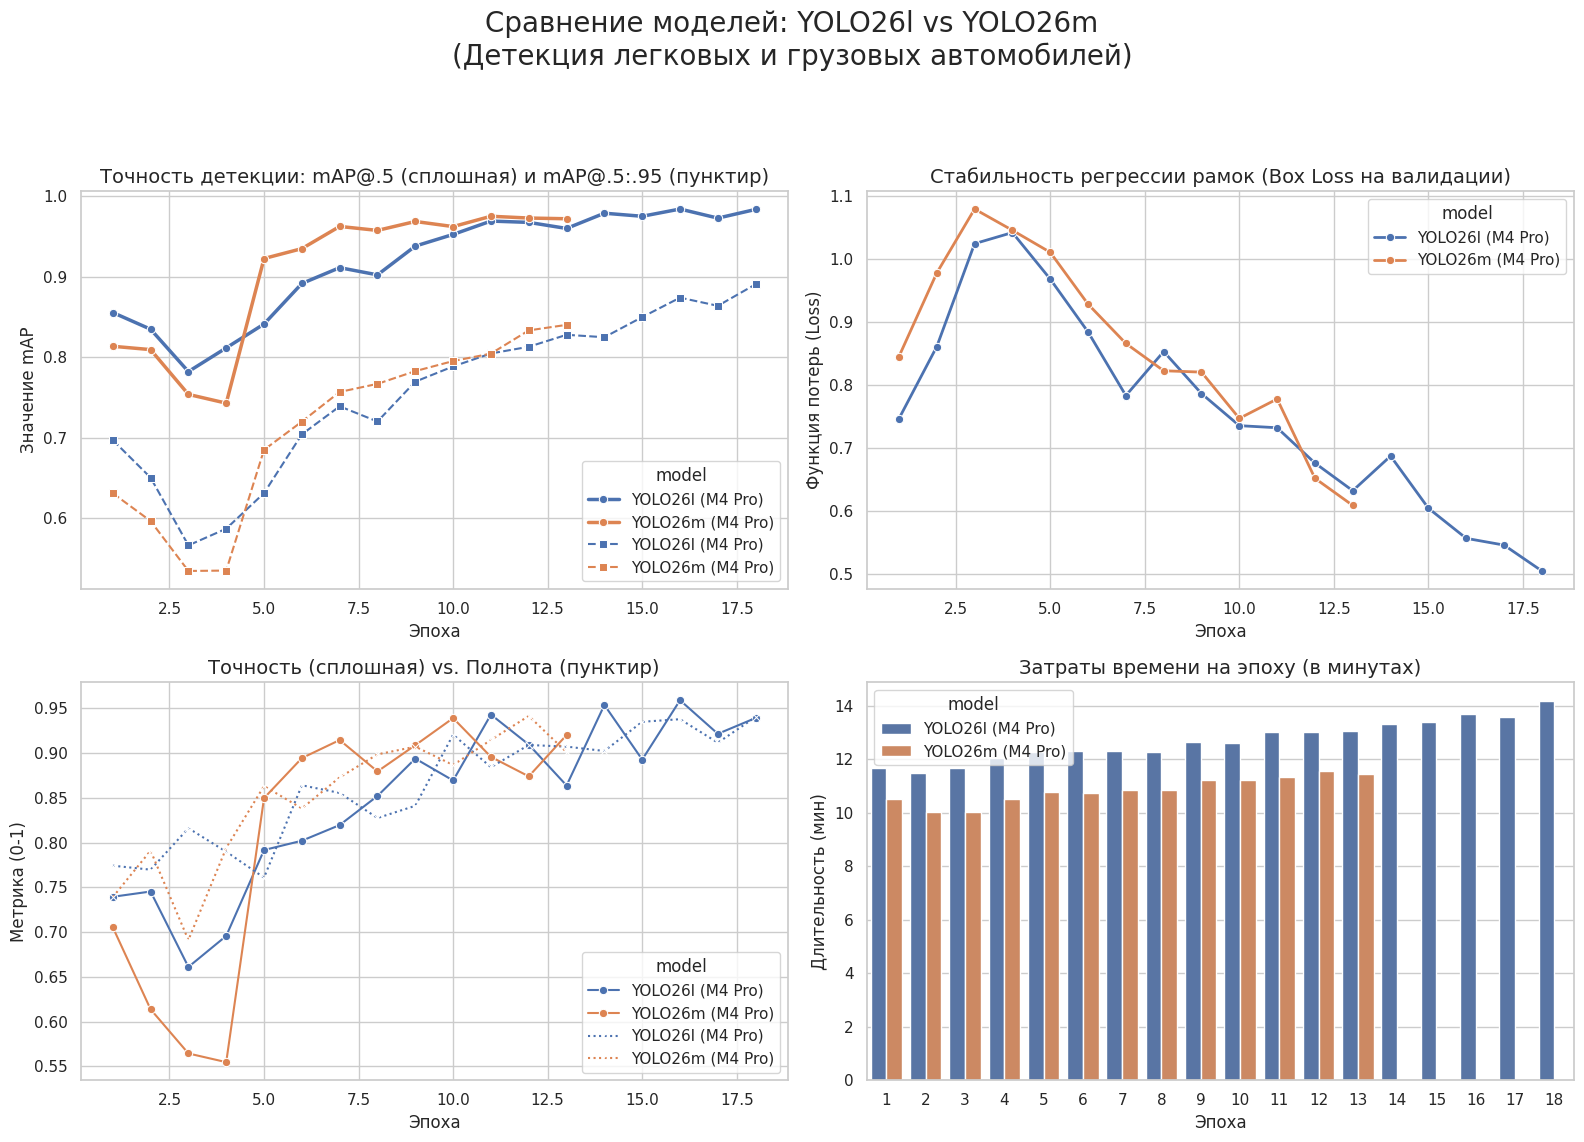

In [3]:
def process_logs(file_path, model_label):
    df = pl.read_csv(file_path)

    return df.with_columns(
        [
            pl.lit(model_label).alias("model"),
            (
                (pl.col("time").diff().fill_null(pl.col("time").first())) / 60
            ).alias("epoch_time"),
        ]
    )


df_l = process_logs(
    ROOT + "models/training_results/demo_detection_v3e18.csv", "YOLO26l (M4 Pro)"
)
df_m = process_logs(
    ROOT + "models/training_results/demo_detection_v4e13.csv", "YOLO26m (M4 Pro)"
)

df_combined = pl.concat([df_l, df_m])

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(
    "Сравнение моделей: YOLO26l vs YOLO26m"
    + "\n(Детекция легковых и грузовых автомобилей)",
    fontsize=20,
)

sns.lineplot(
    data=df_combined,
    x="epoch",
    y="metrics/mAP50(B)",
    hue="model",
    ax=axes[0, 0],
    marker="o",
    linewidth=2.5,
)
sns.lineplot(
    data=df_combined,
    x="epoch",
    y="metrics/mAP50-95(B)",
    hue="model",
    ax=axes[0, 0],
    marker="s",
    linestyle="--",
)
axes[0, 0].set_title(
    "Точность детекции: mAP@.5 (сплошная) и mAP@.5:.95 (пунктир)", fontsize=14
)
axes[0, 0].set_ylabel("Значение mAP")
axes[0, 0].set_xlabel("Эпоха")

sns.lineplot(
    data=df_combined,
    x="epoch",
    y="val/box_loss",
    hue="model",
    ax=axes[0, 1],
    marker="o",
    linewidth=2,
)
axes[0, 1].set_title(
    "Стабильность регрессии рамок (Box Loss на валидации)", fontsize=14
)
axes[0, 1].set_ylabel("Функция потерь (Loss)")
axes[0, 1].set_xlabel("Эпоха")

sns.lineplot(
    data=df_combined,
    x="epoch",
    y="metrics/precision(B)",
    hue="model",
    ax=axes[1, 0],
    marker="o",
)
sns.lineplot(
    data=df_combined,
    x="epoch",
    y="metrics/recall(B)",
    hue="model",
    ax=axes[1, 0],
    marker="x",
    linestyle=":",
)
axes[1, 0].set_title("Точность (сплошная) vs. Полнота (пунктир)", fontsize=14)
axes[1, 0].set_ylabel("Метрика (0-1)")
axes[1, 0].set_xlabel("Эпоха")

sns.barplot(
    data=df_combined, x="epoch", y="epoch_time", hue="model", ax=axes[1, 1]
)
axes[1, 1].set_title("Затраты времени на эпоху (в минутах)", fontsize=14)
axes[1, 1].set_ylabel("Длительность (мин)")
axes[1, 1].set_xlabel("Эпоха")

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.savefig(
    ROOT + "models/training_results/demo_detection_comparison_dashboard.png",
    dpi=300,
)
plt.show()
